# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).


# [1]. Reading Data
[1.1] Loading the data
The dataset is available in two forms

.csv file
SQLite Database
In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently. 
Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [3]:
# REFERED FROM APPLIED AI COURSE VIDEOS
# using SQLite Table to read data.
con = sqlite3.connect('C:/Users/Excel/Desktop/vins/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con)
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 1
    return 0

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,0,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# [2.1] Data Cleaning: Deduplication
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:

In [4]:
display=pd.read_sql_query("""
SELECT *
FROM Reviews 
WHERE Score !=3 and userID='AR5J8UI46CURR'
ORDER BY ProductID
""",con)

In [5]:
print(display.shape)
display.head()

(5, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [6]:
#Sorting the data according to productID in ascending order 
sorted_data=filtered_data.sort_values('ProductId', axis=0,ascending=True) 

In [7]:
# drop the duplicate data 
final=sorted_data.drop_duplicates(subset={'UserId',"ProfileName","Time","Text"},keep="first",inplace=False)

In [8]:
final.shape

(46072, 10)

In [9]:
#checking to see how much % of data is still remaining 
(final["Id"].size*1.0)/(filtered_data["Id"].size*1.0)*100

92.144

In [10]:
# we know that helpfullness numerator is always LESSTHAN EQUALTO  helpfulness of denominator
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print(final.shape)
final["Score"].value_counts()

(46071, 10)


0    38479
1     7592
Name: Score, dtype: int64

Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

# [3] Preprocessing
[3.1]. Preprocessing Review Text
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

0. Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
8. After which we collect the words used to describe positive and negative reviews

In [11]:
#refered from applied ai course videos
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1; 

2
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [12]:

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Excel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
#refered from applied AI Course
import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'s', 'they', 'the', 'not', 'having', 'ourselves', 'only', 'that', 'yourself', 'hasn', 'same', 'hadn', 'ma', 'has', 'weren', 'theirs', 'through', 'wasn', 'she', 'won', 'don', 'll', 't', 'of', 'against', 'can', 'are', 'again', "you'll", 'other', 'too', "shouldn't", 'off', 'some', 'there', 'out', 'all', 'so', 'aren', 'wouldn', 'which', 'been', 'doing', "it's", 'nor', 'didn', 'once', 'isn', 'these', "you're", 'why', 'in', 'just', 'from', 'does', "weren't", 'above', "couldn't", 'had', 'over', 'on', 'while', 'then', 'or', "mightn't", 'this', 'm', 'did', 'more', 'how', 'doesn', 'himself', "don't", 'during', "mustn't", 'most', "isn't", 'am', 'hers', 'because', 're', 'him', 'do', 'shouldn', 'each', "you'd", 'whom', 'below', 'were', "wasn't", 'his', 'what', 'any', 'my', 'between', 'will', 'to', "should've", "didn't", "she's", 'than', 'should', 'a', 've', 'but', 'her', 'by', 'it', "hasn't", 'your', 'me', 'our', 'i', 'mightn', 'ain', 'where', "shan't", 'down', 'when', 'its', "doesn't", 'both', 'w

In [14]:
#refer from applied ai course videos
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1


In [15]:
final['preprocessedtext']=final_string

In [16]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [17]:
import sqlite3
con = sqlite3.connect("final.sqlite")

In [18]:
cleaned_data = pd.read_sql_query("select * from Reviews", con)


In [19]:
cleaned_data.shape

(46071, 12)

In [117]:
length_text=final["preprocessedtext"].apply(lambda x: len(str(x).split(" ")))
length_text.head()

1146     17
1145     37
28086    16
28087    11
38740    84
Name: preprocessedtext, dtype: int64

In [21]:
length_text.shape

(46071,)

# Bag of Words with brute

NOTE: WE USING THE BIGRAM FOR BETTER PERFORMANCE

In [22]:

# this is all xi's set 
final.shape

(46071, 11)

In [23]:
# we taken yi's as score which is called as label
score=final['Score']

In [24]:
score.shape

(46071,)

In [25]:
final["Time"] = pd.to_datetime(final["Time"], unit = "s")
final = final.sort_values(by = "Time")

In [26]:
X=final['preprocessedtext']
Y=final['Score']

In [27]:
X.shape

(46071,)

In [29]:
#refered from applied ai sample solution
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33,shuffle=False) # this is Time based splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33,shuffle=False)


print(X_train.shape, y_train.shape)                                                
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)






(20680,) (20680,)
(10187,) (10187,)
(15204,) (15204,)


In [30]:
# we are converting the into one hot encoding 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=1000,ngram_range=(1,2))
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)
                                                
print("After BOW VEC")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)


After BOW VEC
(20680, 1000) (20680,)
(10187, 1000) (10187,)
(15204, 1000) (15204,)


# FINDING THE BEST K USING SIMPLE FORLOOP

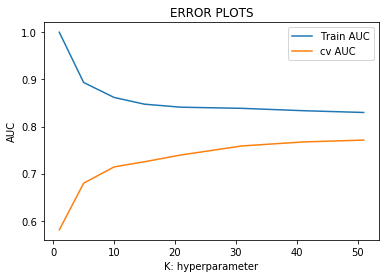

In [31]:
#refer from assignment solution
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    neigh.fit(X_train_bow, y_train)
    y_train_pred = []
    n = X_train_bow.shape[0]#we defining all data 
    for i in range(0 ,n, 1000):# pseudocode which is batch wise because of memory issue 
        y_train_pred.extend(neigh.predict_proba(X_train_bow[i:i+1000])[:,1])# we should find the probability by giving index[:,1] it will take 2 column 
                                                                             
    n = X_cv_bow.shape[0]
    y_cv_pred = []
    for i in range(0 ,n, 1000):
        y_cv_pred.extend(neigh.predict_proba(X_cv_bow[i:i+1000])[:,1])
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='cv AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()    

      
        

OBSERVATION:
1. From this error plot i got best k as 15 .
2. yes! we can take k =40 ,50,30 which this values cv auc is too close to train auc.
3. but i have iterated this value for confusion matrix i didnt get better confusion matrix.
4. when i have iterated with k=15 it get a better confusion matrix compare to others.

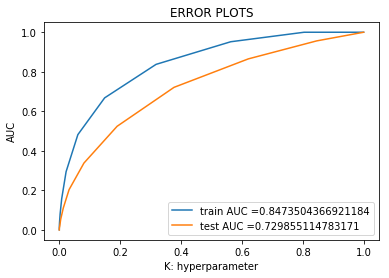

In [32]:
from sklearn.neighbors import  KNeighborsClassifier
# i have tried its k =(40,50,30,25) but k=15 is best.i have iterated so many k for confusion matrix but i got k=15 is best
neigh = KNeighborsClassifier(n_neighbors=15,algorithm='brute')
neigh.fit(X_train_bow, y_train)
                             
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_train_pred = []
n=X_train_bow.shape[0]               
for i in range(0,n,1000):
    y_train_pred.extend(neigh.predict_proba(X_train_bow[i:i+1000])[:,1])
y_test_pred=[]
n=X_test_bow.shape[0]
for i in range(0,n,1000):
    y_test_pred.extend(neigh.predict_proba(X_test_bow[i:i+1000])[:,1])
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()





observation : AUC should greater 0.5 for performance of the model and think its near to 1  its good model. 

# confusion matrix (BOW ,brute)

In [33]:
#REFERED FROM ASSIGNMENT SOLUTION OF APPLIED AI
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
y_train_pred = []
n=X_train_bow.shape[0]               
for i in range(0,n,1000):
    y_train_pred.extend(neigh.predict(X_train_bow[i:i+1000]))
y_test_pred=[]
n=X_test_bow.shape[0]
for i in range(0,n,1000):
    y_test_pred.extend(neigh.predict(X_test_bow[i:i+1000]))
confusionmat_train=confusion_matrix(y_train,y_train_pred)
print(confusionmat_train)
print("Test confusion matrix")
confusionmat_test=confusion_matrix(y_test,y_test_pred)
print(confusionmat_test)

Train confusion matrix
[[17614    48]
 [ 2773   245]]
Test confusion matrix
[[12353    58]
 [ 2640   153]]


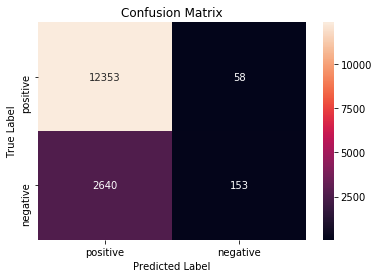

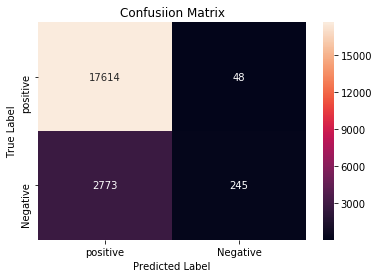

In [34]:
import seaborn as sns
class_label = ["positive","negative"]
df_cm = pd.DataFrame(confusionmat_test, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

import seaborn as sns
class_label = [ "positive","Negative"]
df_cm = pd.DataFrame(confusionmat_train, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

observation : some what the model is with better accuracy. 


# TF-IDF with brute

In [39]:
# we defining our xi's and yi's
Y=final['Score']
X=final['preprocessedtext']


In [41]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33,shuffle=False) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33,shuffle=False)

print(X_train.shape, y_train.shape)                                                
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)




# we are converting the into one hot encoding 
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=3000,ngram_range=(1,2))
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tf = vectorizer.transform(X_train)
X_cv_tf = vectorizer.transform(X_cv)
X_test_tf = vectorizer.transform(X_test)
                                                
print("After TFIDF VEC")
print(X_train_tf.shape, y_train.shape)
print(X_cv_tf.shape, y_cv.shape)
print(X_test_tf.shape, y_test.shape)


(20680,) (20680,)
(10187,) (10187,)
(15204,) (15204,)
After TFIDF VEC
(20680, 3000) (20680,)
(10187, 3000) (10187,)
(15204, 3000) (15204,)


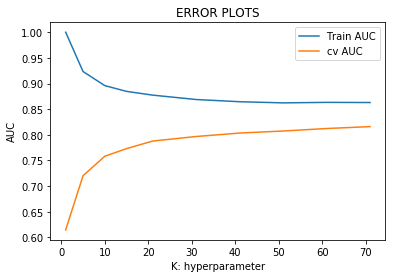

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51,61,71]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    neigh.fit(X_train_tf, y_train)
    y_train_pred = []
    n = X_train_tf.shape[0]
    for i in range(0 ,n, 1000):
        y_train_pred.extend(neigh.predict_proba(X_train_tf[i:i+1000])[:,1])
    n = X_cv_tf.shape[0]
    y_cv_pred = []
    for i in range(0 ,n, 1000):
        y_cv_pred.extend(neigh.predict_proba(X_cv_tf[i:i+1000])[:,1])
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='cv AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()    

      

OBSERVATION:
1. From this error plot i got best k as 21 .
2. yes! we can take k =40 ,50,30 which this values cv auc is too close to train auc.
3. but i have iterated this value for confusion matrix i didnt get better confusion matrix.
4. when i have iterated with k=21 it get a better confusion matrix compare to others.

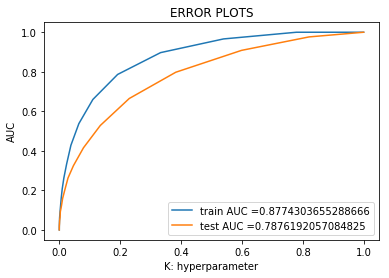

In [43]:
from sklearn.neighbors import  KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=21,algorithm='brute')
neigh.fit(X_train_tf, y_train)
                             
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_train_pred = []
n=X_train_tf.shape[0]               
for i in range(0,n,1000):
    y_train_pred.extend(neigh.predict_proba(X_train_tf[i:i+1000])[:,1])
y_test_pred=[]
n=X_test_tf.shape[0]
for i in range(0,n,1000):
    y_test_pred.extend(neigh.predict_proba(X_test_tf[i:i+1000])[:,1])
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


observation : AUC should greater 0.5 for performance of the model and think its near to 1 its good model.

# confusion matrix(TFIDF,brute)

In [44]:
from sklearn.metrics import confusion_matrix

y_train_pred = []
n=X_train_tf.shape[0]               
for i in range(0,n,1000):
    y_train_pred.extend(neigh.predict(X_train_tf[i:i+1000]))
y_test_pred=[]
n=X_test_tf.shape[0]
for i in range(0,n,1000):
    y_test_pred.extend(neigh.predict(X_test_tf[i:i+1000]))
cm_traintf=confusion_matrix(y_train,y_train_pred)
cm_testtf=confusion_matrix(y_test,y_test_pred)
print(cm_traintf)
print(cm_testtf)

[[17552   110]
 [ 2537   481]]
[[12322    89]
 [ 2450   343]]


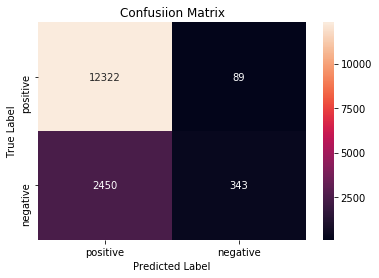

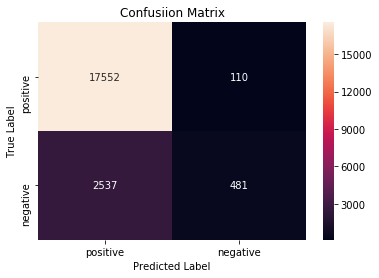

In [45]:
import seaborn as sns
class_label = [ "positive","negative"]
df_cm = pd.DataFrame(cm_testtf, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

import seaborn as sns
class_label = [ "positive","negative"]
df_cm = pd.DataFrame(cm_traintf, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

observation:my model its better than BOW 

# kd tree


# BAG OF WORDS(KDTREE)

In [46]:
from random import sample 
X=final['preprocessedtext'].sample(n=20000)
Y=final['Score'].sample(n=20000)

In [47]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33,shuffle=False) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33,shuffle=False)


print(X_train.shape, y_train.shape)                                                
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)




# we are converting the into one hot encoding 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10,max_features=500,ngram_range=(1,2))
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)
                                                
print("After BOW VEC")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)


(8978,) (8978,)
(4422,) (4422,)
(6600,) (6600,)
After BOW VEC
(8978, 500) (8978,)
(4422, 500) (4422,)
(6600, 500) (6600,)


In [48]:
type(X_train_bow)

scipy.sparse.csr.csr_matrix

In [49]:
type(X_train_bow)

scipy.sparse.csr.csr_matrix

In [50]:
from sklearn.preprocessing import StandardScaler
standardized_vec = StandardScaler(with_mean=False)
# here it will learn mu and sigma
standardized_vec.fit(X_train_bow)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


StandardScaler(copy=True, with_mean=False, with_std=True)

In [51]:
X_train_bow = standardized_vec.transform(X_train_bow)
print(X_train_bow.shape)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(8978, 500)


In [52]:
X_cv_bow  = standardized_vec.transform(X_cv_bow)
print(X_cv_bow.shape)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(4422, 500)


In [53]:
X_test_bow = standardized_vec.transform(X_test_bow)
print(X_test_bow.shape)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(6600, 500)


In [54]:
X_train_bow=X_train_bow.todense()

In [55]:
type(X_train_bow)

numpy.matrixlib.defmatrix.matrix

In [56]:
d=(length_text)
df=pd.DataFrame(d)


In [57]:
df_train=df[:8978]

In [58]:
type(df)

pandas.core.frame.DataFrame

In [59]:
df_train.shape

(8978, 1)

In [60]:
X_train_bow=np.concatenate((X_train_bow,df_train),axis=1)

In [61]:
X_train_bow.shape

(8978, 501)

In [62]:
type(X_cv_bow)

scipy.sparse.csr.csr_matrix

In [63]:
X_cv_bow=X_cv_bow.todense()

In [64]:
df_cv=df[8978:13400]

In [65]:
df_cv.shape

(4422, 1)

In [66]:
X_cv_bow=np.concatenate((X_cv_bow,df_cv),axis=1)

In [67]:
X_cv_bow.shape

(4422, 501)

In [68]:
X_test_bow=X_test_bow.todense()

In [69]:
df_test=df[13400:20000]

In [70]:
X_test_bow=np.concatenate((X_test_bow,df_test),axis=1)

In [71]:
X_test_bow.shape

(6600, 501)

In [72]:
type(X_test_bow)

numpy.matrixlib.defmatrix.matrix

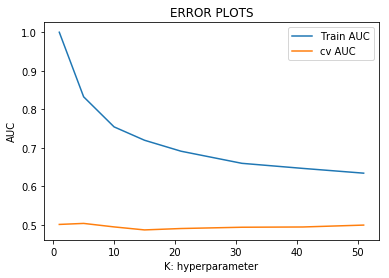

In [73]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    neigh.fit(X_train_bow, y_train)
    y_train_pred = []
    n = len(X_train_bow)
    for i in range(0 ,n, 1000):
        y_train_pred.extend(neigh.predict_proba(X_train_bow[i:i+1000])[:,1])
    n = len(X_cv_bow)
    y_cv_pred = []
    for i in range(0 ,n, 1000):
        y_cv_pred.extend(neigh.predict_proba(X_cv_bow[i:i+1000])[:,1])
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='cv AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()    


OBSERVATION : I have picked my best k as 5 .am getting actually for k as 6 for better confusion matrix but even number as k leads to ambiguity.

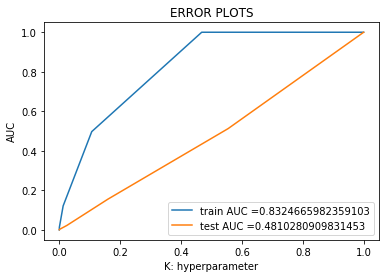

In [81]:
from sklearn.neighbors import  KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5,algorithm='kd_tree')
neigh.fit(X_train_bow, y_train)
                             
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_train_pred = []
n=len(X_train_bow)              
for i in range(0,n,1000):
    y_train_pred.extend(neigh.predict_proba(X_train_bow[i:i+1000])[:,1])
y_test_pred=[]
n=len(X_test_bow)
for i in range(0,n,1000):
    y_test_pred.extend(neigh.predict_proba(X_test_bow[i:i+1000])[:,1])
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


OBSERVATION : WITH ALGORITHM  KDTREE ITS DOES'NT WORK WELL WHEN COMPARED TO ALGORITHM BRUTE

# CONFUSION MATRIX (BOW,KDTREE)

In [82]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
y_train_pred = []
n=len(X_train)               
for i in range(0,n,1000):
    y_train_pred.extend(neigh.predict(X_train_bow[i:i+1000]))
y_test_pred=[]
n=len(X_test)
for i in range(0,n,1000):
    y_test_pred.extend(neigh.predict(X_test_bow[i:i+1000]))
cm_bw_train=confusion_matrix(y_train,y_train_pred)
print(cm_bw_train)
cm_bw_test=confusion_matrix(y_test,y_test_pred)

print(cm_bw_test)

Train confusion matrix
[[7417   95]
 [1288  178]]
[[5314  135]
 [1125   26]]


confusion matrix for test


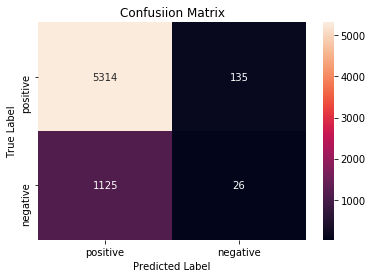

****************************************************************************************************
confusion matrix for train


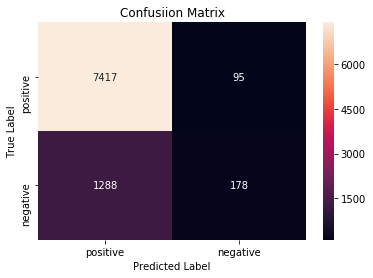

In [83]:
print('confusion matrix for test')
import seaborn as sns
class_label = [ "positive","negative"]
df_cm = pd.DataFrame(cm_bw_test, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
print('*'*100)
print("confusion matrix for train")
import seaborn as sns
class_label = ["positive","negative"]
df_cm = pd.DataFrame(cm_bw_train, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

OBSERVATION : I have picked my best k as 5 .am getting actually for k as 6 for better confusion matrix but even number as k leads to ambiguity.

# TFIDF(KDTREE)

In [84]:
X=final['preprocessedtext'].sample(n=20000)
Y=final['Score'].sample(n=20000)

In [86]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33,shuffle=False) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33,shuffle=False)


print(X_train.shape, y_train.shape)                                                
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)




# we are converting the into one hot encoding 
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer =TfidfVectorizer(min_df=10,max_features=500,ngram_range=(1,2))
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tf = vectorizer.transform(X_train)
X_cv_tf = vectorizer.transform(X_cv)
X_test_tf = vectorizer.transform(X_test)
                                                
print("After tfidf VEC")
print(X_train_tf.shape, y_train.shape)
print(X_cv_tf.shape, y_cv.shape)
print(X_test_tf.shape, y_test.shape)


(8978,) (8978,)
(4422,) (4422,)
(6600,) (6600,)
After tfidf VEC
(8978, 500) (8978,)
(4422, 500) (4422,)
(6600, 500) (6600,)


In [87]:
type(X_train_tf)

scipy.sparse.csr.csr_matrix

In [88]:
from sklearn.preprocessing import StandardScaler
standardized_vec = StandardScaler(with_mean=False)
# here it will learn mu and sigma
standardized_vec.fit(X_train_tf)

StandardScaler(copy=True, with_mean=False, with_std=True)

In [89]:
X_train_tf = standardized_vec.transform(X_train_tf)
print(X_train_tf.shape)


(8978, 500)


In [90]:
X_cv_tf = standardized_vec.transform(X_cv_tf)
print(X_cv_tf.shape)


(4422, 500)


In [91]:
X_test_tf = standardized_vec.transform(X_test_tf)
print(X_test_tf.shape)


(6600, 500)


In [92]:
X_train_tf=X_train_tf.todense()

In [93]:
type(X_train_tf)

numpy.matrixlib.defmatrix.matrix

In [94]:
df_train=df[:8978]

In [95]:
X_train_tf=np.concatenate((X_train_tf,df_train),axis=1)

In [96]:
X_train_tf.shape

(8978, 501)

In [97]:
X_test_tf=X_test_tf.todense()

In [98]:
type(X_test_tf)

numpy.matrixlib.defmatrix.matrix

In [99]:
df_test_tf=df[13400:20000]

In [100]:
X_test_tf=np.concatenate((X_test_tf,df_test_tf),axis=1)

In [101]:
X_test_tf.shape

(6600, 501)

In [102]:
X_cv_tf=X_cv_tf.todense()

In [103]:
type(X_cv_tf)

numpy.matrixlib.defmatrix.matrix

In [104]:
df_cv=df[8978:13400]

In [105]:
X_cv_tf=np.concatenate((X_cv_tf,df_cv),axis=1)

In [106]:
X_cv_tf.shape

(4422, 501)

In [107]:
np.shape(y_cv)

(4422,)

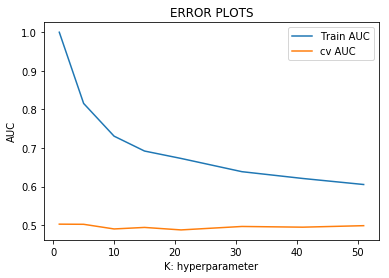

In [108]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    neigh.fit(X_train_tf, y_train)
    y_train_pred = []
    n = len(X_train_tf)
    for i in range(0 ,n, 1000):
        y_train_pred.extend(neigh.predict_proba(X_train_tf[i:i+1000])[:,1])
    n =len(X_cv_tf)
    y_cv_pred = []
    for i in range(0 ,n, 1000):
        y_cv_pred.extend(neigh.predict_proba(X_cv_tf[i:i+1000])[:,1])
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='cv AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()    


In [109]:
np.shape(y_cv_pred)

(4422,)

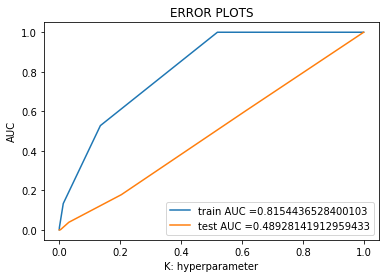

In [112]:
from sklearn.neighbors import  KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5,algorithm='kd_tree')
neigh.fit(X_train_tf, y_train)
                             
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_train_pred = []
n=X_train_tf.shape[0]               
for i in range(0,n,1000):
    y_train_pred.extend(neigh.predict_proba(X_train_tf[i:i+1000])[:,1])
y_test_pred=[]
n=X_test_tf.shape[0]
for i in range(0,n,1000):
    y_test_pred.extend(neigh.predict_proba(X_test_tf[i:i+1000])[:,1])
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


OBSERVATION : WITH ALGORITHM KDTREE ITS DOES'NT WORK WELL WHEN COMPARED TO ALGORITHM BRUTE

# CONFUSION MATRIX

In [113]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
y_train_pred = []
n=X_train_tf.shape[0]               
for i in range(0,n,1000):
    y_train_pred.extend(neigh.predict(X_train_tf[i:i+1000]))
y_test_pred=[]
n=X_test_tf.shape[0]
for i in range(0,n,1000):
    y_test_pred.extend(neigh.predict(X_test_tf[i:i+1000]))
cm_traintf=confusion_matrix(y_train,y_train_pred)
cm_testtf=confusion_matrix(y_test,y_test_pred)
print(cm_traintf)
print(cm_testtf)

Train confusion matrix
[[7419   98]
 [1266  195]]
[[5340  173]
 [1045   42]]


confusion matrix for test


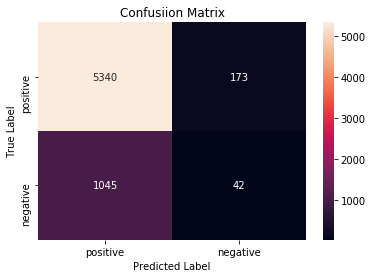

****************************************************************************************************
confusion matrix for train


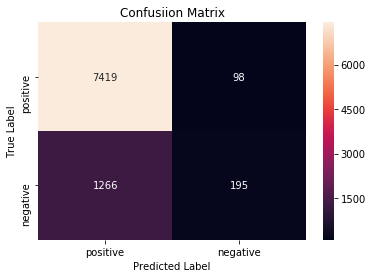

In [114]:
print('confusion matrix for test')
import seaborn as sns
class_label = [ "positive","negative"]
df_cm = pd.DataFrame(cm_testtf, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
print('*'*100)
print("confusion matrix for train")
import seaborn as sns
class_label = [ "positive","negative"]
df_cm = pd.DataFrame(cm_traintf, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# NOTE : Here i have itereated values for k to get better confusion matrix but for my best k =6 ,if we taken k as 6 means it leads to ambiguity so i have taken for better confusion matrix as k =5.

# Conclusion

My prettytable is not working in my notebook

In [115]:
print("BRUTE ALGORITHM ")
from tabulate import tabulate
print(tabulate ([['BOW', 15, 74,84],['TFIDF',21,78,87],['AVG_W2V',5,49.75,82],['TFIDF-W2V',5,50,82]],    headers=['algorithm type', 'best_k','roc_score for test','roc_score for train']))

BRUTE ALGORITHM 
algorithm type      best_k    roc_score for test    roc_score for train
----------------  --------  --------------------  ---------------------
BOW                     15                 74                        84
TFIDF                   21                 78                        87
AVG_W2V                  5                 49.75                     82
TFIDF-W2V                5                 50                        82


In [116]:
print("KD_TREE ALGORITHM ")
from tabulate import tabulate
print(tabulate ([['BOW', 5, 49,83],['TFIDF',5,49,83],['AVG_W2V',5,50,84],['TFIDF-W2V',5,50,84]],    headers=['algorithm type', 'best_k','roc_score for test','roc_score for train']))

KD_TREE ALGORITHM 
algorithm type      best_k    roc_score for test    roc_score for train
----------------  --------  --------------------  ---------------------
BOW                      5                    49                     83
TFIDF                    5                    49                     83
AVG_W2V                  5                    50                     84
TFIDF-W2V                5                    50                     84


Observation: TFIDF WITH BRUTE FORCE IS WORKING BETTER AS COMPARED TO OTHER MODEL